In [45]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.image_dir = os.path.join(root_dir, "Tissues")
        self.mask_dir = os.path.join(root_dir, "Masks", "binary_mask")

        self.image_files = os.listdir(self.image_dir)
        self.mask_files = os.listdir(self.mask_dir)

        # Ensure the lists are sorted for matching image-mask pairs
        self.image_files.sort()
        self.mask_files.sort()

        # Check if the number of images and masks match
        assert len(self.image_files) == len(self.mask_files), "Number of images and masks do not match!"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        mask_name = self.mask_files[idx]

        image_path = os.path.join(self.image_dir, image_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(image_path)
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create an instance of the custom dataset
dataset = CustomDataset(root_dir="G:/down_scaled_level6_train_resized", transform=transform)

In [5]:
from torch.utils.data import random_split

# Split dataset into train and validation sets
total_samples = len(dataset)
train_size = int(0.8 * total_samples)
valid_size = total_samples - train_size

train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

Training Dataset Samples:


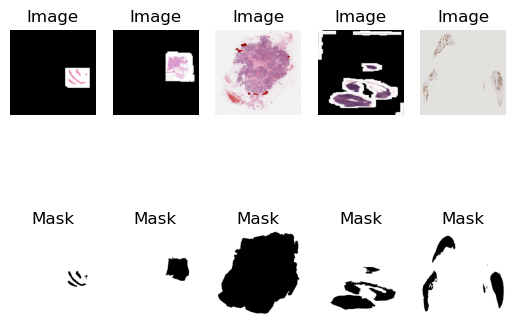


Validation Dataset Samples:


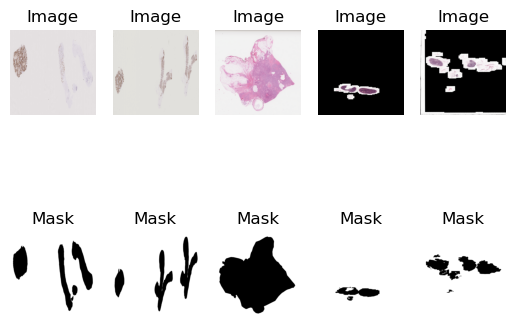

In [14]:
def display_samples(images, masks, num_samples=5):
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute dimensions for correct display
        plt.axis("off")
        plt.title("Image")

        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(masks[i][0], cmap="gray")  # Assuming masks are single-channel
        plt.axis("off")
        plt.title("Mask")

    plt.show()

# Display a few samples from the training dataset
print("Training Dataset Samples:")
for images, masks in train_dataloader:
    display_samples(images, masks)
    break  # Display only the first batch

# Display a few samples from the validation dataset
print("\nValidation Dataset Samples:")
for images, masks in valid_dataloader:
    display_samples(images, masks)
    break  # Display only the first batch

In [ ]:
"""
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
])


train_dataset.dataset.transform = train_transform
valid_dataset.dataset.transform = valid_transform
"""

In [6]:
# Create data loaders for train and validation sets
bs = 8

train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=bs, shuffle=False)

In [36]:
import torch.nn as nn

# Define the U-Net architecture
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2),  # Increase the upsampling factor
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        x1 = self.encoder(x)

        # Decoder
        x2 = self.decoder(x1)

        return x2
    
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the device
print("Device:", device)

# Set the number of input channels and output channels
# Input channels: 3 for RGB images, 1 for grayscale
# Output channels: 1 for binary segmentation mask
in_channels = 3 
out_channels = 1  

# Create an instance of the UNet model
model = UNet(in_channels, out_channels)
model.to(device)

# Print the model architecture
print(model)

Device: cpu
UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)


In [37]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [38]:
from tqdm import tqdm
from sklearn.metrics import jaccard_score

# Set the number of epochs
num_epochs = 10

# Initialize lists to store loss values for plotting
train_losses = []
valid_losses = []

# Training loop
for epoch in range(1, num_epochs+1):
    
    model.train()
    epoch_train_loss = 0.0
    for images, masks in  tqdm(train_dataloader, desc=f"Epoch {epoch}/{num_epochs}", unit="batch"):
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)

        # Calculate the loss
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation
    
    model.eval()  
    epoch_valid_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(valid_dataloader, desc=f"Epoch {epoch}/{num_epochs}", unit="batch"):
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate the validation loss
            valid_loss = criterion(outputs, masks)
            epoch_valid_loss += valid_loss.item()

    # Calculate average validation loss for the epoch
    avg_valid_loss = epoch_valid_loss / len(valid_dataloader)
    valid_losses.append(avg_valid_loss)
    
    # Save the trained model
    torch.save(model.state_dict(), f"unet_model_{epoch}.pth")

    # Print losses
    print(f"Epoch {epoch}/{num_epochs}, Train Loss: {avg_train_loss}")
    print(f"Epoch {epoch}/{num_epochs}, Valid Loss: {avg_valid_loss}")

Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.25s/batch]


Epoch 1/10, Train Loss: 0.19508986423412958
Epoch 1/10, Valid Loss: 0.15818276007970175


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.34s/batch]


Epoch 2/10, Train Loss: 0.1451192076007525
Epoch 2/10, Valid Loss: 0.15220649043718973


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.30s/batch]


Epoch 3/10, Train Loss: 0.1375317166869839
Epoch 3/10, Valid Loss: 0.13935267428557077


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.23s/batch]


Epoch 4/10, Train Loss: 0.13142893525461355
Epoch 4/10, Valid Loss: 0.13474666327238083


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.38s/batch]


Epoch 5/10, Train Loss: 0.1252915064493815
Epoch 5/10, Valid Loss: 0.12364350756009419


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.30s/batch]


Epoch 6/10, Train Loss: 0.11840027198195457
Epoch 6/10, Valid Loss: 0.13866532345612845


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.33s/batch]


Epoch 7/10, Train Loss: 0.11012406026323636
Epoch 7/10, Valid Loss: 0.11433504770199458


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.27s/batch]


Epoch 8/10, Train Loss: 0.11146641770998637
Epoch 8/10, Valid Loss: 0.10782721390326817


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.28s/batch]


Epoch 9/10, Train Loss: 0.10590808559209108
Epoch 9/10, Valid Loss: 0.09304324040810268


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.43s/batch]

Epoch 10/10, Train Loss: 0.10031136125326157
Epoch 10/10, Valid Loss: 0.09124817947546641


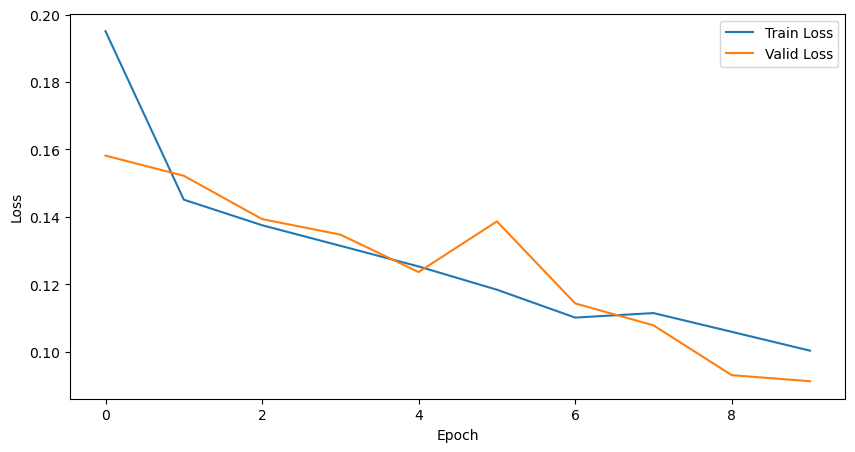

In [39]:
# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
selected_ep = 9
saved_model_path = f"unet_model{selected_ep}.pth"
model.load_state_dict(torch.load(saved_model_path))

<All keys matched successfully>

In [43]:
# Load the test dataset
test_dataset = CustomDataset(root_dir="G:/down_scaled_level6_test_resized", transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [51]:
from sklearn.metrics import jaccard_score

# Initialize lists to store predictions and ground truth masks
all_predictions = []
all_ground_truths = []

# Perform inference
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, masks in tqdm(test_dataloader):
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        predictions = model(images)

        # Store predictions and ground truth masks
        all_predictions.append(predictions.cpu().numpy())
        all_ground_truths.append(masks.cpu().numpy())

# Concatenate predictions and ground truth masks along the batch dimension
all_predictions = np.concatenate(all_predictions, axis=0)
all_ground_truths = np.concatenate(all_ground_truths, axis=0)

# Flatten and convert to binary arrays
binary_threshold = 0.5
y_true_binary = (all_ground_truths > 0.5).flatten()
y_pred_binary = (all_predictions > binary_threshold).flatten()

# Calculate Jaccard accuracy
jaccard_acc = jaccard_score(y_true_binary, y_pred_binary, average='binary')

print(f"Jaccard Accuracy: {jaccard_acc}")

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.80it/s]


Jaccard Accuracy: 0.8504796069335511


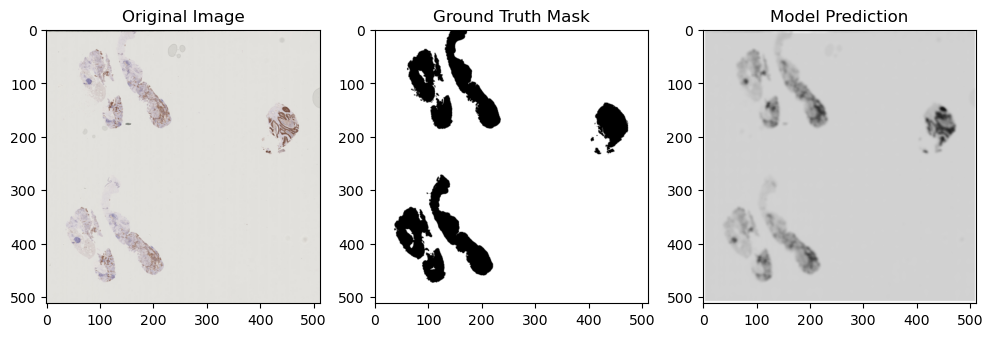

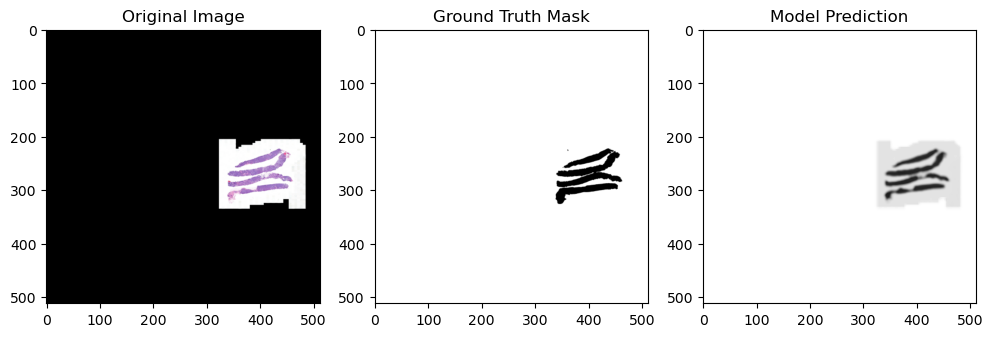

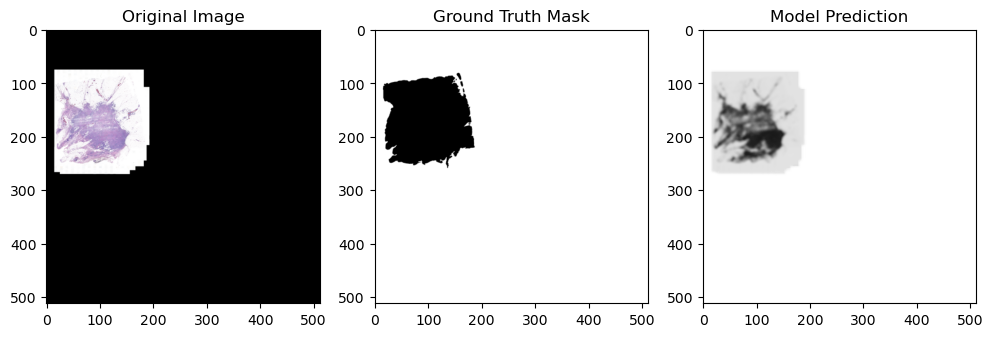

In [56]:
# Visualize samples
num_samples_to_visualize = 3
for i in range(num_samples_to_visualize):
    # Assuming each element in the dataset is a tuple (image, mask)
    sample = test_dataset[i]
    
    # Convert image and mask tensors to numpy arrays
    image = sample[0].numpy()
    mask = sample[1].numpy()

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image.transpose((1, 2, 0)))  # Assuming the image is in the shape (3, 512, 512)
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(mask[0], cmap='gray')  # Assuming the mask is in the shape (1, 512, 512)
    plt.title("Ground Truth Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(all_predictions[i, 0], cmap='gray')  # Assuming the model prediction is a numpy array
    plt.title("Model Prediction")

    plt.show()